In [ ]:
# pip install contextily

In [1]:
import sys
sys.path.insert(1, '../../Tools/')
from dea_tools.coastal import get_coastlines


In [2]:
import geopandas as gpd
from shapely.geometry import box, Point
import contextily as ctx
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from matplotlib.image import imread
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe



def load_animation_data(y, x, width, ratio):

    # Create bbox
    point_gdf = gpd.GeoDataFrame(geometry=[Point(x, y)], 
                                 crs='EPSG:4326').to_crs('EPSG:3577')
    xmin = point_gdf.geometry.x.item() - width
    xmax = point_gdf.geometry.x.item() + width
    ymin = point_gdf.geometry.y.item() - (width * ratio)
    ymax = point_gdf.geometry.y.item() + (width * ratio)
    bounds = [xmin, ymin, xmax, ymax]
    bbox = gpd.GeoDataFrame(geometry=[box(*bounds)], 
                            crs='EPSG:3577')
    
    
    deacl_gdf = get_coastlines(bbox=bbox)

#     # Set up WFS requests for annual coastlines & rates of change statistics
#     deacl_coastlines_wfs = 'https://geoserver.dea.ga.gov.au/geoserver/wfs?' \
#                            'service=WFS&version=1.1.0&request=GetFeature&' \
#                            'typeName=dea:shorelines_annual&maxFeatures=1000&' \
#                           f'bbox={ymin},{xmin},{ymax},{xmax},urn:ogc:def:crs:EPSG:4326'

#     # Load data from WFS and set CRS
#     deacl_gdf = gpd.read_file(deacl_coastlines_wfs)
#     deacl_gdf.crs = 'EPSG:3577'

    # Load data
    # deacl_gdf = gpd.read_file('/g/data/r78/DEACoastlines/DEACoastlines_annualcoastlines_v1.1.4.shp', bbox=bbox)

    # Clip to extent of satellite data 
    deacl_gdf = gpd.overlay(deacl_gdf, bbox)
    deacl_gdf = deacl_gdf.dissolve('year')

    # Apply colours
    norm = matplotlib.colors.Normalize(vmin=0, vmax=len(deacl_gdf.index))
    cmap = matplotlib.cm.get_cmap('inferno')
    rgba = cmap(norm(deacl_gdf.reset_index().index))
    deacl_gdf['color'] = list(rgba)
    deacl_gdf.at['2020', 'color'] = 'white'
    deacl_gdf.plot(color=deacl_gdf['color'], figsize=(10, 10))
    
    return deacl_gdf, bounds

   
def plot_years(site, deacl_gdf, bounds, legend_width, text='bottom', basemap_alpha=0.75, cumulative=False):

    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    
    if text == 'bottom':
        annualshorelines_xy = (1, 0)
        annualshorelines_xytext = (-120, 20)
        annualshorelines_va = 'bottom'
        years_xy = (1, 0)
        years_xytext = (-130, 8.2)
        years_va = 'bottom'
        key_xy = (1, 0)
        key_xybox = (-318, 110)
        key_box_alignment = (0.5, 1)
    else:
        annualshorelines_xy = (1, 1)
        annualshorelines_xytext = (-120, -20)
        annualshorelines_va = 'top'
        years_xy = (1, 1)
        years_xytext = (-130, -20)
        years_va = 'top'
        key_xy = (1, 1)
        key_xybox = (-318, -112)
        key_box_alignment = (0.5, 0)

    for i, year in enumerate(deacl_gdf.index):

        print(year)

        # Plot data
        if cumulative:
            years = [i for i in range(1988, int(year) + 1)]
            years_gdf = deacl_gdf.loc[years]   
            years_gdf.plot(ax=ax, color=years_gdf['color'], linewidth=3)
            
        else:
            
            year_gdf = deacl_gdf.loc[[year]]
            year_gdf.plot(ax=ax, color=year_gdf['color'], linewidth=3)
        
        # Set bounds
        xmin, ymin, xmax, ymax = bounds
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        ax.patch.set_facecolor('black')       

        # Add basemap
        ctx.add_basemap(ax, 
                        source='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}', 
                        crs='EPSG:3577',
                        alpha=basemap_alpha)        
        
        # # Add logo overlay
        # arr_lena = imread('/g/data/r78/DEACoastlines/visualisation/images/DEACoastlines_logo.png')
        # imagebox = OffsetImage(arr_lena, zoom=0.14)
        # ab = AnnotationBbox(imagebox, 
        #                     xy=(0, 1), 
        #                     xycoords='axes fraction', 
        #                     xybox=(10, -10), 
        #                     boxcoords='offset points', 
        #                     box_alignment=(0, 1), 
        #                     frameon=False) 
        # ax.add_artist(ab)
            
        # Add overlay text
        ax.annotate('Median\nshoreline\nposition', 
                    xy=annualshorelines_xy, 
                    xycoords='axes fraction', 
                    xytext=annualshorelines_xytext,
                    textcoords='offset points', 
                    ha='left', 
                    va=annualshorelines_va,
                    size=20, 
                    color='white')
        ax.annotate(year, 
                    xy=years_xy, 
                    xycoords='axes fraction', 
                    xytext=years_xytext,
                    textcoords='offset points', 
                    ha='right', 
                    va=years_va,
                    size=80, 
                    color='white') 
        
        # Add scalebar
        scalebar = AnchoredSizeBar(ax.transData,
                               legend_width, f'{legend_width} m', 'lower left', 
                               pad=2.5, 
                               color='white',
                               frameon=False,
                               sep=10,
                               fontproperties=fm.FontProperties(size=18)) 
        ax.add_artist(scalebar)       

        # Export to file
        ax.axis('off')
        plt.savefig(f'Frames/{site}_{year}.png',bbox_inches='tight',transparent=True, pad_inches=0, dpi=150)
        plt.cla()
        
    plt.clf()
    

def plot_alltime(site, deacl_gdf, bounds, legend_width, text='bottom', basemap_alpha=0.75, final_year=2019):
    
    # Creat plot
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    years = [i for i in range(1988, final_year + 1)]
    deacl_gdf.loc[years].plot(ax=ax, color=deacl_gdf.color, linewidth=3)
    deacl_gdf.loc[[final_year]].plot(ax=ax, color="#fdffe8", linewidth=4)
    xmin, ymin, xmax, ymax = bounds
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.patch.set_facecolor('black')    

    # Add basemap
    ctx.add_basemap(ax, 
                    # source='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}', 
                    source='http://ecn.t3.tiles.virtualearth.net/tiles/a{r}', 
                    crs='EPSG:3577',
                    alpha=basemap_alpha)
  

    


    
    # # Add logo overlay
    # arr_lena = imread('/g/data/r78/DEACoastlines/visualisation/images/DEACoastlines_logo.png')
    # imagebox = OffsetImage(arr_lena, zoom=0.14)
    # ab = AnnotationBbox(imagebox, 
    #                     xy=(0, 1), 
    #                     xycoords='axes fraction', 
    #                     xybox=(10, -10), 
    #                     boxcoords='offset points', 
    #                     box_alignment=(0, 1), 
    #                     frameon=False)
    # ax.add_artist(ab)
    
    if text == 'bottom':
        annualshorelines_xy = (1, 0)
        annualshorelines_xytext = (-120, 20)
        annualshorelines_va = 'bottom'
        years_xy = (1, 0)
        years_xytext = (-130, 8.2)
        years_va = 'bottom'
        key_xy = (1, 0)
        key_xybox = (-318, 110)
        key_box_alignment = (0.5, 1)
    else:
        annualshorelines_xy = (1, 1)
        annualshorelines_xytext = (-120, -20)
        annualshorelines_va = 'top'
        years_xy = (1, 1)
        years_xytext = (-130, -20)
        years_va = 'top'
        key_xy = (1, 1)
        key_xybox = (-318, -112)
        key_box_alignment = (0.5, 0)
    
    # Add overlay text
    ax.annotate('Annual\nshoreline\npositions', 
                xy=annualshorelines_xy, 
                xycoords='axes fraction', 
                xytext=annualshorelines_xytext,
                textcoords='offset points', 
                ha='left', 
                va=annualshorelines_va,
                size=20, 
                color='white')
    ax.annotate(f'1988-{final_year}', 
                xy=years_xy, 
                xycoords='axes fraction', 
                xytext=years_xytext,
                textcoords='offset points', 
                ha='right', 
                va=years_va,
                size=70, 
                color='white')
    
    # # Add image overlay
    # arr_lena = imread('/g/data/r78/DEACoastlines/visualisation/images/DEACoastlines_key.png')
    # imagebox = OffsetImage(arr_lena, zoom=0.41)
    # ab = AnnotationBbox(imagebox, 
    #                     xy=key_xy, 
    #                     xycoords='axes fraction', 
    #                     xybox=key_xybox, 
    #                     boxcoords='offset points', 
    #                     box_alignment=key_box_alignment, 
    #                     frameon=False)
    # ax.add_artist(ab)

    # Add scalebar
    scalebar = AnchoredSizeBar(ax.transData,
                           legend_width, f'{legend_width} m', 'lower left', 
                           pad=2.5, 
                           color='white',
                           frameon=False,
                           sep=10,
                           fontproperties=fm.FontProperties(size=18)) 
    ax.add_artist(scalebar);

    # Export to file
    ax.axis('off')
    plt.savefig(f'Frames/{site}_{final_year + 1}.png',bbox_inches='tight',transparent=True, pad_inches=0, dpi=150)


UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7ff86e32ea40>

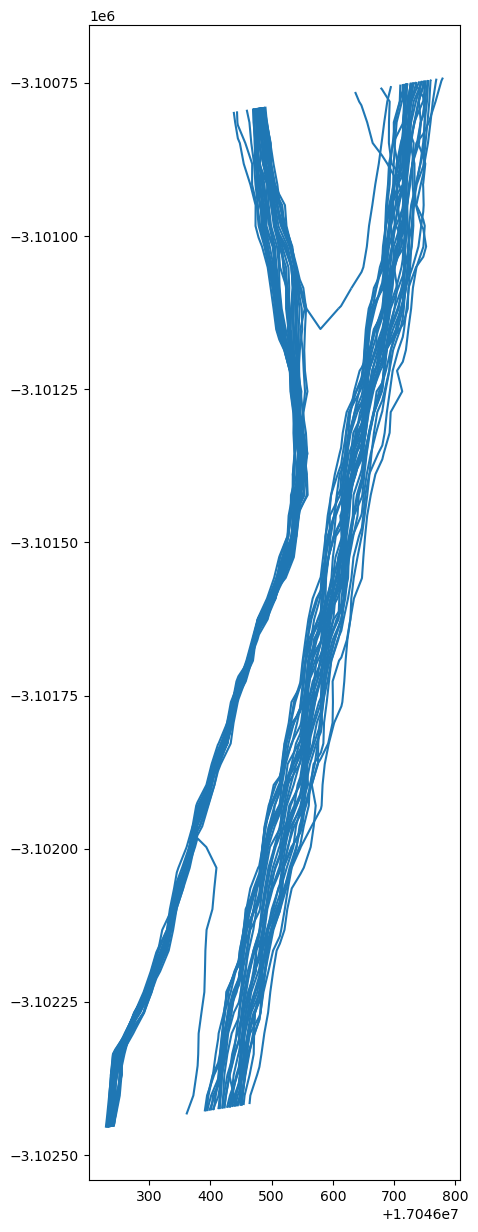

In [4]:
# Creat plot
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
deacl_gdf.to_crs("EPSG:3857").plot(ax=ax)
 
# Add basemap
ctx.add_basemap(ax, 
                # source='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}', 
                source='http://ecn.t3.tiles.virtualearth.net/tiles/a{r}.jpeg?g=1', 
                # crs='EPSG:3577',
                alpha=1)

In [ ]:
from PIL import Image
import urllib.request
URL = 'http://ecn.t3.tiles.virtualearth.net/tiles/a3112112233102.jpeg?g=1'
with urllib.request.urlopen(URL) as url:
    img = Image.open(url)
    img.show()

/tmp/ipykernel_455/1857978420.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('inferno')


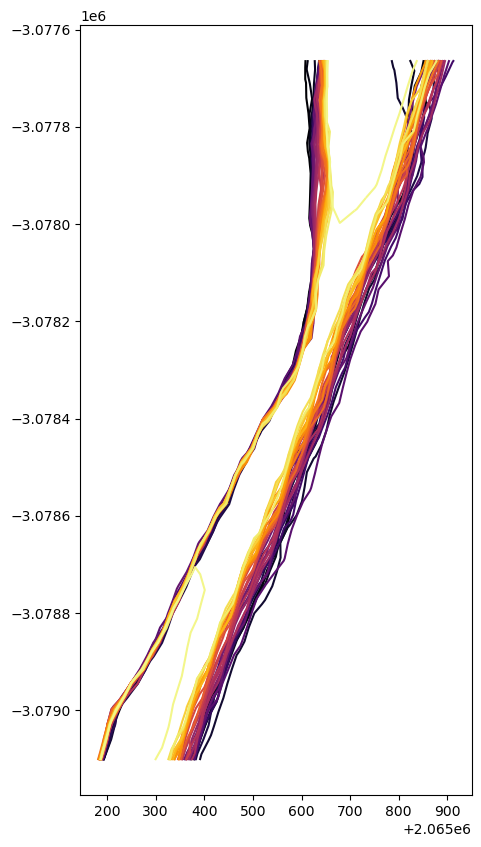

In [3]:
# Get bounding box of data
site = 'nobbys'
text='bottom'
y, x = -32.9219, 151.79677
width = 850
ratio = 0.5
legend_width = 200

# Get bounding box of data
site = 'twilightcove'
text='bottom'
y, x = -32.276, 126.057
width = 3000
ratio = 0.5
legend_width = 1000

# Get bounding box of data
site = 'barbeach'
text='bottom'
y, x = -32.945, 151.764
width = 900
ratio = 0.5
legend_width = 100

# Get bounding box of data
site = 'byronbay'
text='top'
y, x = -28.6385, 153.624053
width = 1500
ratio = 0.5
legend_width = 200

# Get bounding box of data
site = 'tweedheads'
text='top'
y, x = -28.166068, 153.535
width = 2500
ratio = 0.5
legend_width = 200

# Get bounding box of data
site = 'bowlinggreen'
text='top'
y, x = -19.3045, 147.393
width = 2400
ratio = 0.5
legend_width = 500

# Get bounding box of data
site = 'adelaidesandbank'
text='top'
y, x = -34.7585, 138.4895
width = 1200
ratio = 0.9
legend_width = 100

# Get bounding box of data
site = 'tiwi'
text='top'
y, x = -11.331698, 130.339211
width = 2000
ratio = 0.9
legend_width = 100

# Get bounding box of data
site = 'whyalla'
text='bottom'
y, x = -33.008, 137.6035
width = 1300
ratio = 0.9
legend_width = 100

# Get bounding box of data
site = 'oldbar'
text='bottom'
y, x = -31.973865, 152.589180
width = 650
ratio = 0.65
legend_width = 100

# Get bounding box of data
site = 'ettalong'
text='bottom'
y, x = -33.524181, 151.327640
width = 650
ratio = 0.65
legend_width = 100

# Get bounding box of data
site = 'theentrance'
text='bottom'
y, x = -33.332, 151.513
width = 2500
ratio = 1
legend_width = 300

# Get bounding box of data
site = 'theentrancenorth'
text='bottom'
y, x = -33.318098, 151.522
width = 600
ratio = 0.6
legend_width = 100


# Get bounding box of data
site = 'bribie'
text='bottom'
y, x = -26.824474, 153.1335
width = 900
ratio = 0.8
legend_width = 100



# Load data
deacl_gdf, bounds = load_animation_data(y, x, width, ratio)

In [ ]:
# plot_years(site, deacl_gdf, bounds, legend_width, text, basemap_alpha=0.7, cumulative=True)


In [ ]:
pip install contextily==1.1

In [ ]:
plot_alltime(site, deacl_gdf, bounds, legend_width, text, basemap_alpha=0.85, final_year=2022)


In [ ]:
!ffmpeg -y -r 10 -start_number 1988 -i Frames/{site}_%4d.png -c:v libx264 -vf "fps=10,format=yuv420p,pad=ceil(iw/2)*2:ceil(ih/2)*2" -threads 7 temp.mp4
!ffmpeg -y -i temp.mp4 -filter_complex "[0]trim=0:5[hold],[0][hold]concat[extended],[extended][0]overlay" -pix_fmt yuv420p -c:a copy deacoastlines_basemap_{site}.mp4
# !ffmpeg -y -i deacoastlines_{site}_animation.mp4 -vf "minterpolate=fps=30:mi_mode=blend" -threads 7 test.mp4
# !ffmpeg -y -t 2 -i deacoastlines_{site}_animation.mp4 -vf "minterpolate='mi_mode=mci:mc_mode=aobmc:vsbmc=1:fps=120:me=fss'" test.mp4 -threads 7


